In [1]:
import pandas as pd
import georinex as gr
import misc
from plots import *
import matplotlib.dates as mdates
import datetime
import matplotlib
import copy

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader, PosReader, RinexReader

# Prepare the data

In [2]:
# Load log files
measurements_log = ['Raw', 'Fix']
#measurements_RINEX = ['C1C']
measurements_RINEX = sum([[f"{y}{x}" for y in ['C', 'L', 'D', 'S']] for x in ['1C', '1L', '5Q', '2I', '5P', '5A']], [])
logs = []

log = LogReader(manufacturer="Google", device="Pixel 7", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_GooglePixel7_20230217095501.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230480000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="Google", device="Pixel Watch", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_GooglePixelWatch_20230814145154_modified.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20232260000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="OnePlus", device="Nord 2", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_OnePlusNord2_20230303105504.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230620000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="Samsung", device="A52", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_SamsungA52_20230317141230.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230760000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

log = LogReader(manufacturer="Xiaomi", device="11T", specifiedTags=measurements_log, mode="logger", 
                filepath="../.data/2023_Dataset_Hervanta/S1_static/raw/log_Xiaomi11_20230303095606.txt")
log.ref = RinexReader('Reference',
                      '../.data/2023_Dataset_Hervanta/S1_static/_reference/base/TAUN00FIN_R_20230620000_01D_30S_MO.rnx',
                      tlim=[log.raw.iloc[0].name.isoformat(), log.raw.iloc[-1].name.isoformat()],
                      meas=measurements_RINEX, sampling=30)
logs.append(log)

device_list = [log.device for log in logs]

In [3]:
logs[0].raw.prn.unique()

array(['G15-L1', 'G23-L1', 'G30-L1', 'G23-L5', 'G30-L5', 'C21-L1',
       'C26-L1', 'C30-L1', 'C40-L1', 'C45-L1', 'C24-L5', 'C29-L5',
       'C33-L5', 'C42-L5', 'E03-L1', 'E09-L1', 'E24-L1', 'E26-L1',
       'E03-L5', 'E09-L5', 'E24-L5', 'E26-L5', 'G08-L1', 'G17-L1',
       'G24-L1', 'G08-L5', 'G24-L5', 'R13-L1', 'C24-L1', 'C29-L1',
       'C33-L1', 'C42-L1', 'C21-L5', 'C26-L5', 'C30-L5', 'C40-L5',
       'C45-L5', 'E05-L1', 'E13-L1', 'E25-L1', 'E31-L1', 'E05-L5',
       'E13-L5', 'E25-L5', 'E31-L5', 'G13-L1', 'R14-L1', 'R04-L1',
       'G14-L1', 'G14-L5', 'C10-L1', 'G10-L1', 'G10-L5', 'G21-L1',
       'J195-L1', 'J195-L5', 'E33-L1', 'E33-L5', 'R05-L1', 'G19-L1'],
      dtype=object)

In [4]:
logs[0].raw.loc[logs[0].raw['prn'].isin(['J195-L1']), ['TimeNanos', 'AccumulatedDeltaRangeMeters', 'PhaseVelocity', 'PhaseError']]


,TimeNanos,AccumulatedDeltaRangeMeters,PhaseVelocity,PhaseError
datetime,,,,
2023-02-17 08:18:24.000,1.542736e+12,4.496730,NaN,NaN
2023-02-17 08:18:25.000,1.543736e+12,4.499988,0.003258,NaN
2023-02-17 08:18:30.000,1.548736e+12,4.498902,-0.000217,-0.000695
2023-02-17 08:18:31.000,1.549736e+12,4.502160,0.003258,0.003475
2023-02-17 08:18:32.000,1.550736e+12,4.496730,-0.005430,-0.008688
...,...,...,...,...
2023-02-17 08:39:58.999,2.837736e+12,30846.209965,146.713049,0.231425
2023-02-17 08:39:59.999,2.838736e+12,30992.967246,146.757281,0.044231
2023-02-17 08:40:01.999,2.840736e+12,31286.613329,146.823042,0.032881


In [5]:
# only keep GPS provider
log.fix = log.fix.loc[log.fix["provider"] == 'GPS']

In [6]:
# Compute ENU errors
ref_enu = [61.44922404, 23.8562781, 162.711]
for log in logs:
    log.fix[["east", "north", "up"]] = log.fix.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')
    
    log.diff = log.fix[["east", "north", "up"]].copy()
    
    log.diff[["2D_error"]] = log.diff.apply(
        lambda row: misc.getHorizontalError(row['east'], row['north']), 
        axis='columns', result_type='expand')
    
    log.diff[["3D_error"]] = log.diff.apply(
        lambda row: misc.get3DError(row['east'], row['north'], row['up']), 
        axis='columns', result_type='expand')

    print(f"--- {log.device} ---")
    print(log.diff.describe())

--- Pixel 7 ---
              east        north           up     2D_error     3D_error
count  3169.000000  3169.000000  3169.000000  3169.000000  3169.000000
mean    -12.000680    -0.806966     2.530620    13.310786    14.515084
std      35.299592    11.865637     1.311160    36.801287    36.454612
min    -167.507519   -74.833770    -0.945141     0.499089     1.167275
25%      -2.416438     0.653036     1.548997     1.364514     2.441068
50%      -1.386920     1.092363     2.888991     1.848141     3.384709
75%      -0.924462     1.655990     3.287500     3.409349     4.745906
max     124.580622    68.533222    20.487416   167.648560   167.651464
--- Pixel Watch ---
              east        north           up     2D_error     3D_error
count  1107.000000  1107.000000  1107.000000  1107.000000  1107.000000
mean      0.513459    -1.395790     1.020882     2.260069     3.069734
std       0.839207     1.614166     2.117235     0.641201     1.271891
min      -0.722799    -3.226171    -3.391

# Results

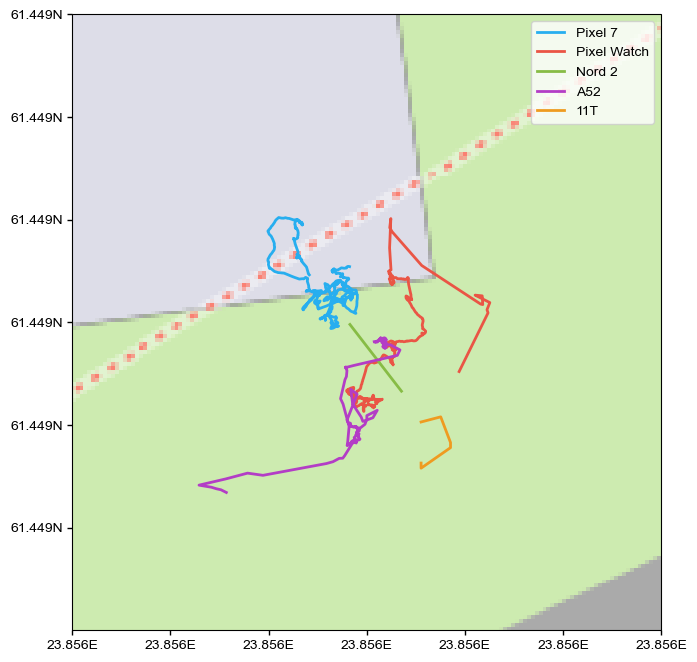

In [7]:
center = ref_enu[:2]
#extent = [center[1] - 0.02, center[1] + 0.005, center[0] - 0.005, center[0] + 0.005]
extent = [center[1] - 0.0002, center[1] + 0.0002, center[0] - 0.0001, center[0] + 0.0001]

locations = {}
for log in logs:
    locations[log.device] = log.fix.loc[log.fix['provider'].isin(['GPS']), ["latitude", "longitude"]]

plotMap(locations=locations, extent=extent, scale=19)

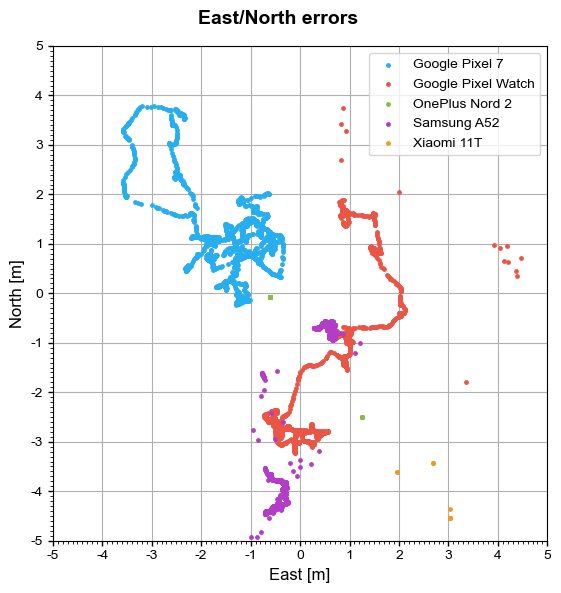

In [8]:
plotEN(logs, lim=5, ticks=[0.1, 1])

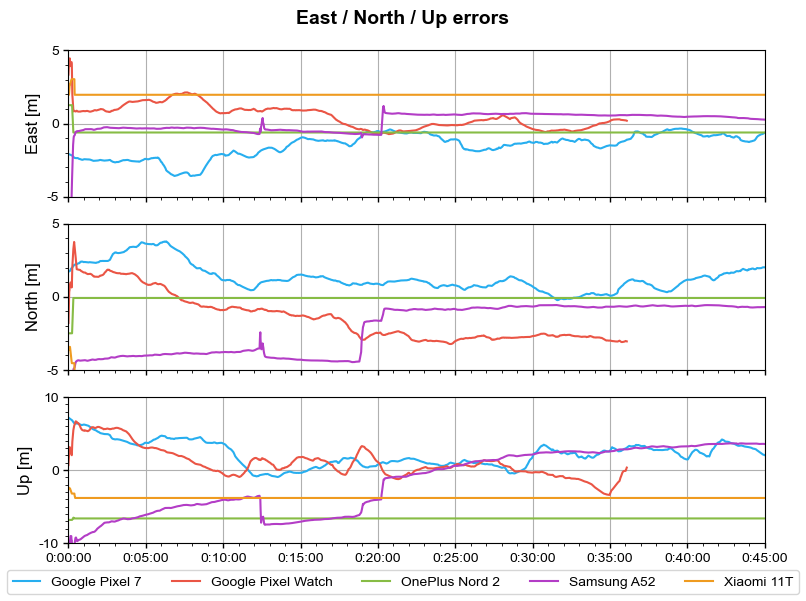

In [9]:
plotENU(logs, lim=[5,5,10], ticks=[1, 5, 1, 5, 1, 10])

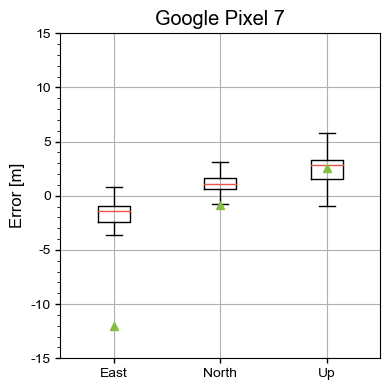

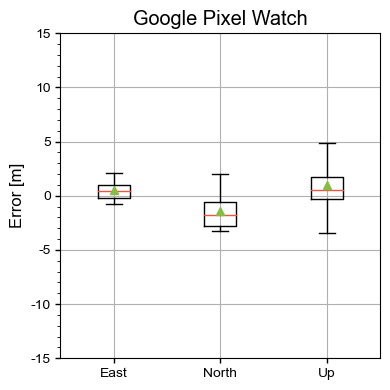

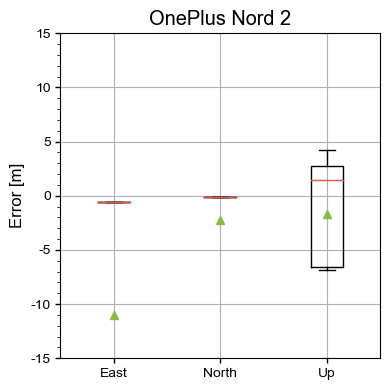

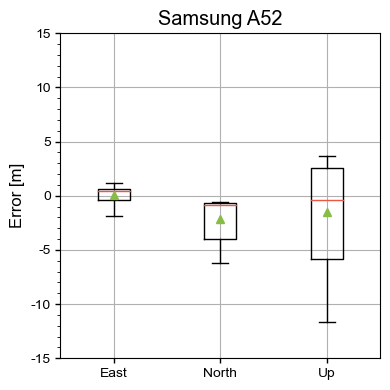

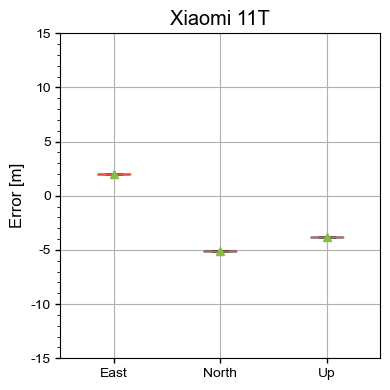

In [10]:
plotStatisticsENU(logs, lim=15, ticks=[1, 5], mode='box')

### Visibility

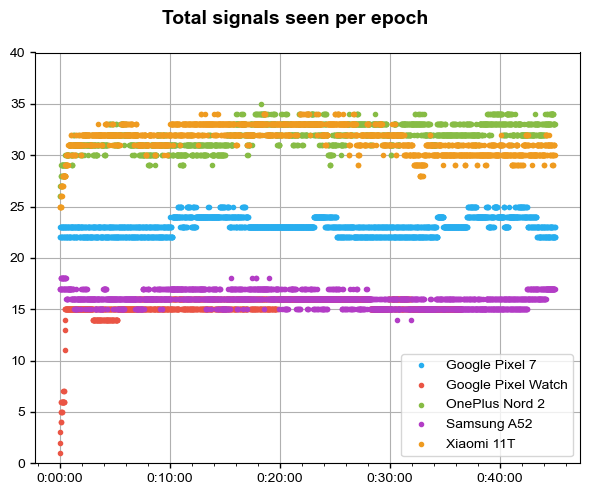

In [11]:
plotTotalSignalsPerEpochs(logs, lim=[0, 40], ticks=[120, 600], mode='signal')

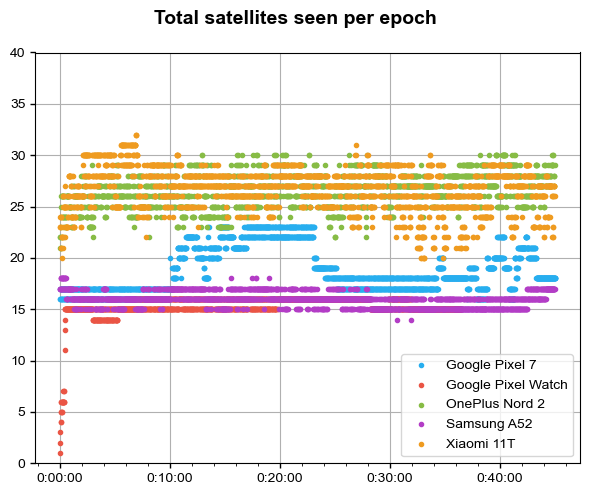

In [12]:
plotTotalSignalsPerEpochs(logs, lim=[0,40], ticks=[120, 600], mode='satellite')

In [56]:
sorted(log.raw[log.raw.prn.str.contains(rf'I[0-9]{{2,3}}-..')]['prn'].unique())

['I01-L5', 'I02-L5', 'I04-L5', 'I06-L5', 'I07-L5']

--- Pixel 7 ---
L1   : 35 (66) - 53.03
L5   : 25 (45) - 55.55555555555556
Total: 60 (111) - 54.05
--- Pixel Watch ---
L1   : 40 (65) - 61.54
L5   : 0 (44) - 0.0
Total: 40 (109) - 36.70
--- Nord 2 ---
L1   : 53 (65) - 81.54
L5   : 29 (43) - 67.44186046511628
Total: 82 (108) - 75.93
--- A52 ---
L1   : 43 (67) - 64.18
L5   : 0 (46) - 0.0
Total: 43 (113) - 38.05
--- 11T ---
L1   : 49 (58) - 84.48
L5   : 28 (38) - 73.68421052631578
Total: 77 (96) - 80.21


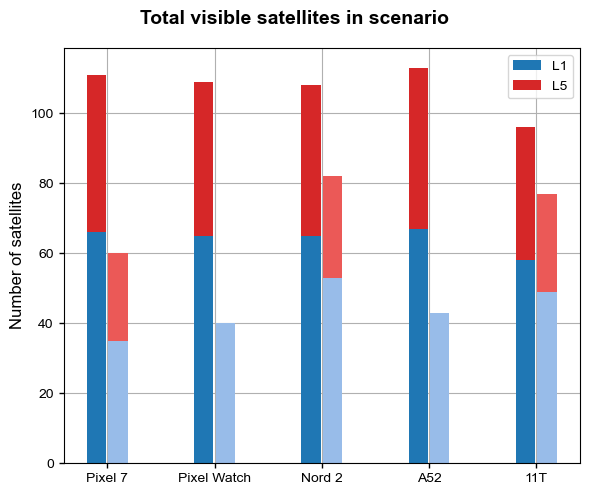

In [13]:
plotTotalSatellitesBar(logs, normalised=False)

Pixel 7          | G: 17 (21) - 81.0%
Pixel Watch      | G: 12 (18) - 66.7%
Nord 2           | G: 23 (22) - 104.5%
A52              | G: 14 (22) - 63.6%
11T              | G: 17 (20) - 85.0%
Pixel 7          | R: 4 (10) - 40.0%
Pixel Watch      | R: 14 (11) - 127.3%
Nord 2           | R: 12 (12) - 100.0%
A52              | R: 10 (11) - 90.9%
11T              | R: 9 (10) - 90.0%
Pixel 7          | E: 18 (20) - 90.0%
Pixel Watch      | E: 9 (18) - 50.0%
Nord 2           | E: 16 (16) - 100.0%
A52              | E: 4 (20) - 20.0%
11T              | E: 19 (18) - 105.6%
Pixel 7          | C: 19 (32) - 59.4%
Pixel Watch      | C: 5 (34) - 14.7%
Nord 2           | C: 31 (33) - 93.9%
A52              | C: 14 (30) - 46.7%
11T              | C: 27 (24) - 112.5%
Pixel 7          | I: 0 (4) - 0.0%
Pixel Watch      | I: 0 (4) - 0.0%
Nord 2           | I: 0 (4) - 0.0%
A52              | I: 0 (4) - 0.0%
11T              | I: 5 (4) - 125.0%
Pixel 7          | S: 0 (7) - 0.0%
Pixel Watch      | S: 0 (7)

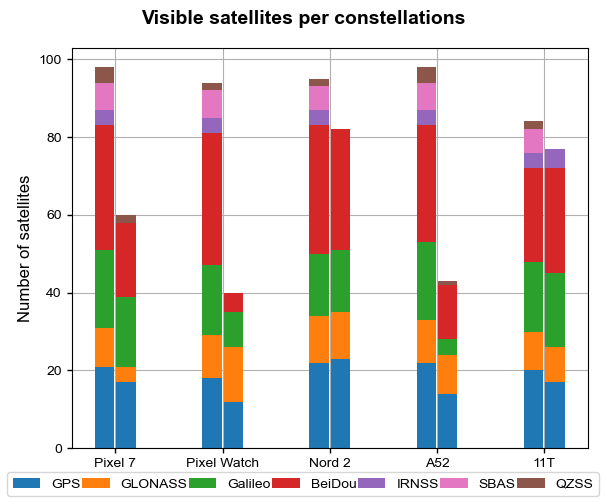

In [14]:
plotSatellitesBarPerSystem(logs, normalised=False)

Pixel 7          | L1: 35 (62) - 56.5%
Pixel Watch      | L1: 40 (61) - 65.6%
Nord 2           | L1: 53 (61) - 86.9%
A52              | L1: 43 (63) - 68.3%
11T              | L1: 49 (54) - 90.7%


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Pixel 7          | L5: 25 (36) - 69.4%
Pixel Watch      | L5: 0 (33) - 0.0%
Nord 2           | L5: 29 (34) - 85.3%
A52              | L5: 0 (35) - 0.0%
11T              | L5: 28 (30) - 93.3%


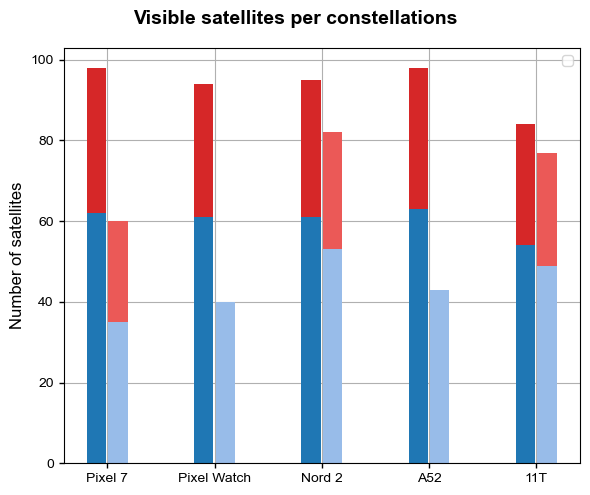

In [15]:
plotSatellitesBarPerFrequency(logs)

Text(0.5, 1.0, 'Time difference between two consecutive signal')

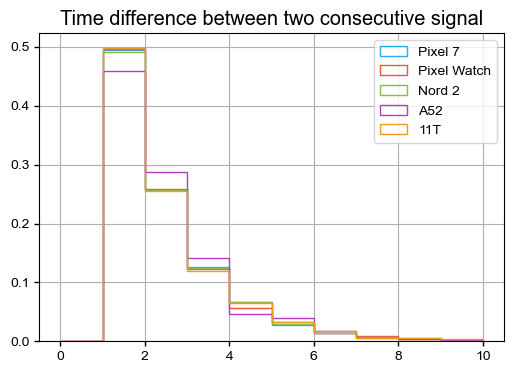

In [16]:
for log in logs:
    dt = log.raw.groupby('prn')['TimeNanos'].diff().values * 1e-9
    plt.hist(dt, range=(0,10), log=False, density=True, histtype='step', label=f"{log.device}")
#plt.ylim([0, 0.6])
plt.legend()
plt.title("Time difference between two consecutive signal")

### Measurements

Pseudoranges

Rows removed 60 (0.100%)
Rows removed 22 (0.069%)
Rows removed 0 (0.000%)
Rows removed 8 (0.019%)
Rows removed 32 (0.039%)


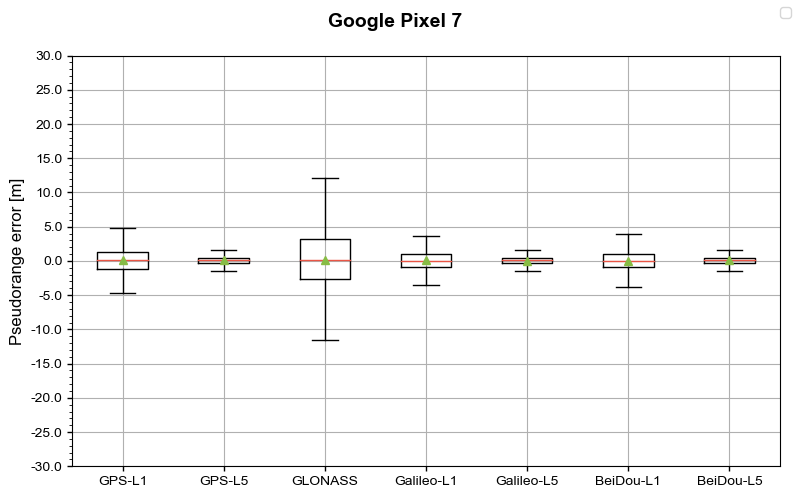

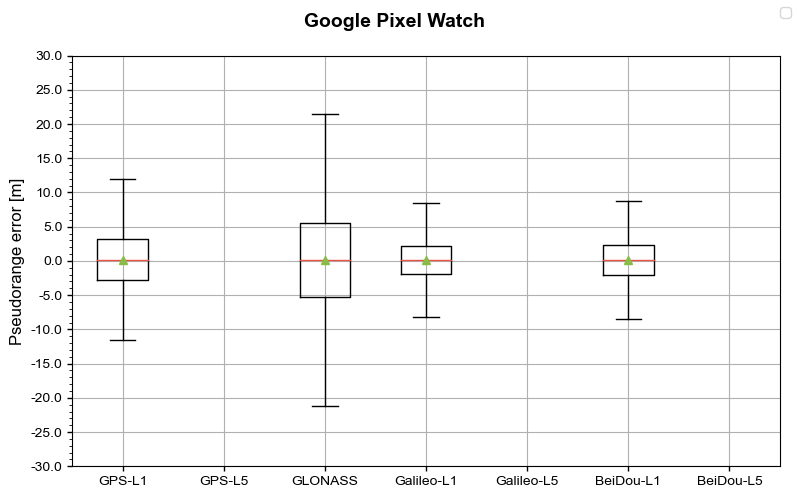

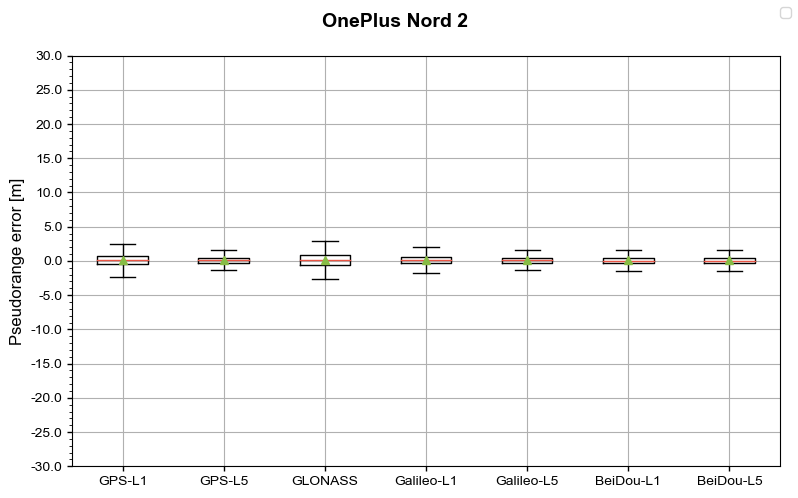

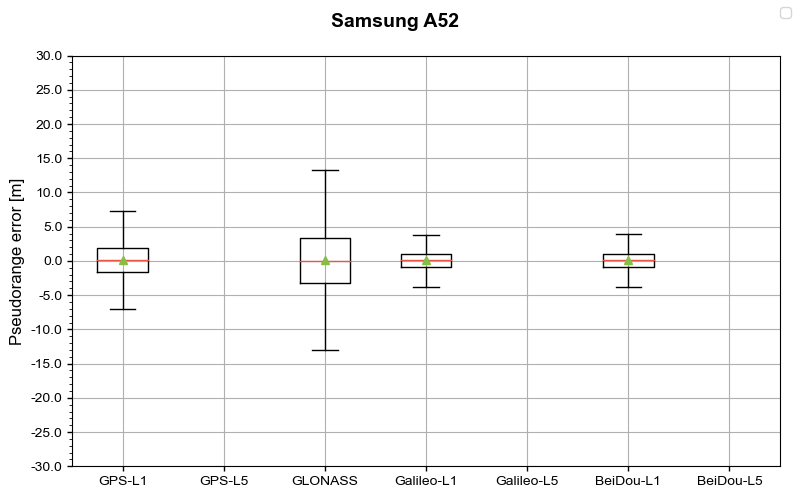

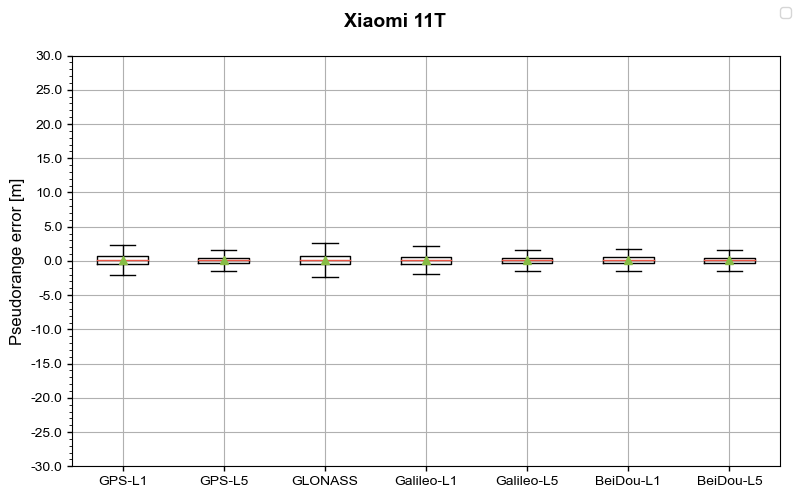

In [17]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw = misc.filterValues(log.raw, 'PseudorangeAcceleration', 300)
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
plotStatisticsDataBox(_logs, 
                      'PseudorangeAcceleration', 
                      'Pseudorange error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,5])

--- Pixel 7 ---
Rows removed 0 (0.000%)
--- Pixel Watch ---
Rows removed 0 (0.000%)
--- Nord 2 ---
Rows removed 0 (0.000%)
--- A52 ---
Rows removed 0 (0.000%)
--- 11T ---
Rows removed 0 (0.000%)
           Pixel 7  Pixel Watch       Nord 2          A52          11T
count  7774.000000  5799.000000  7182.000000  7962.000000  6853.000000
mean      0.060617     0.057543     0.059810     0.072408     0.063351
std       1.767401     0.459257     1.570339     1.694542     0.491555
min    -108.756947   -16.098876   -50.681906   -72.456436   -23.339063
50%       0.058043     0.051152     0.045533     0.061637     0.062853
66.7%     0.079337     0.075821     0.074373     0.083418     0.082935
95%       0.133606     0.133899     0.137735     0.128934     0.129731
99.7%     0.174683     0.174667     0.180499     0.170934     0.177281
max     108.773149    22.944831    50.698849    87.806397    23.510598


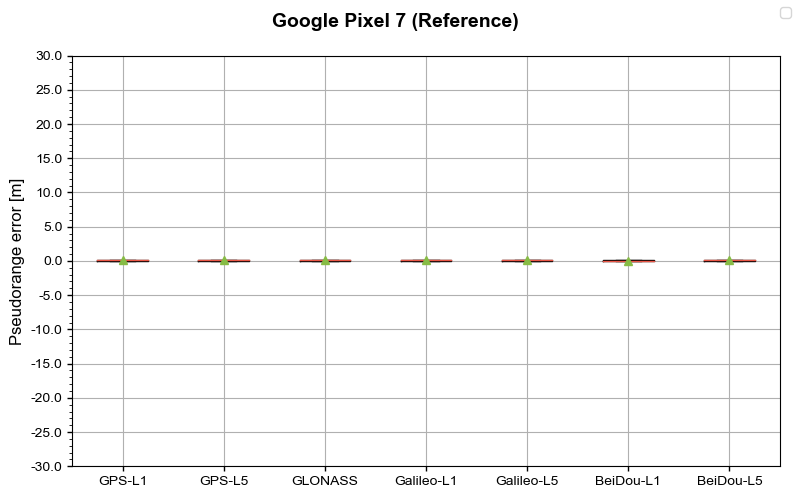

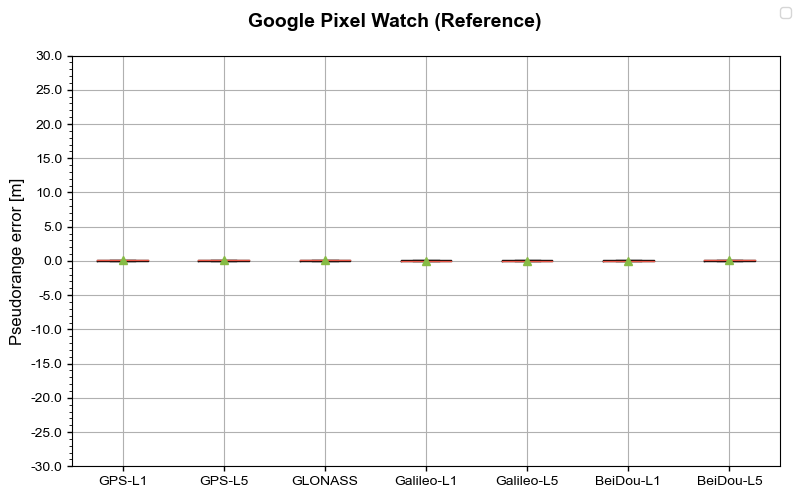

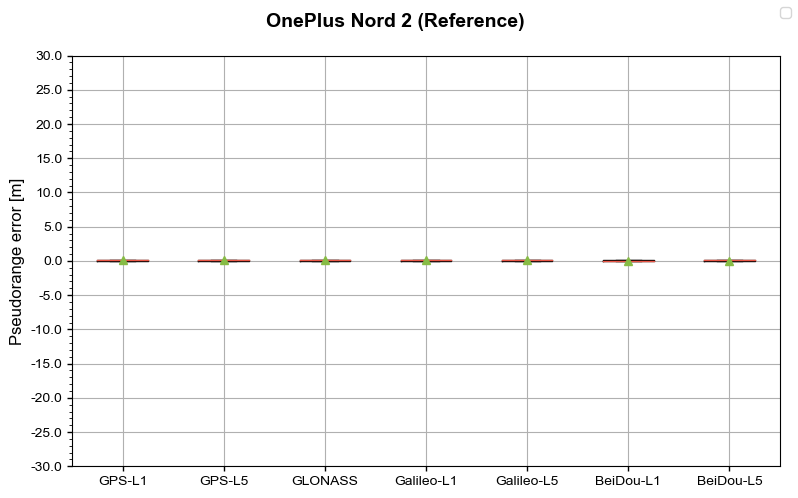

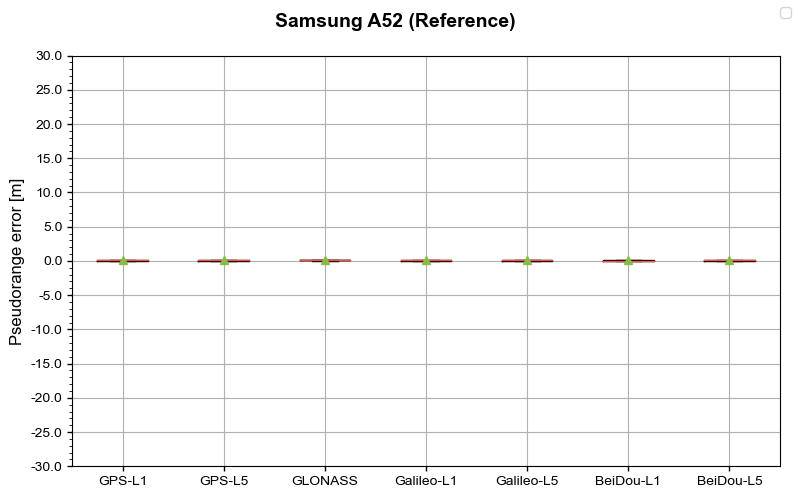

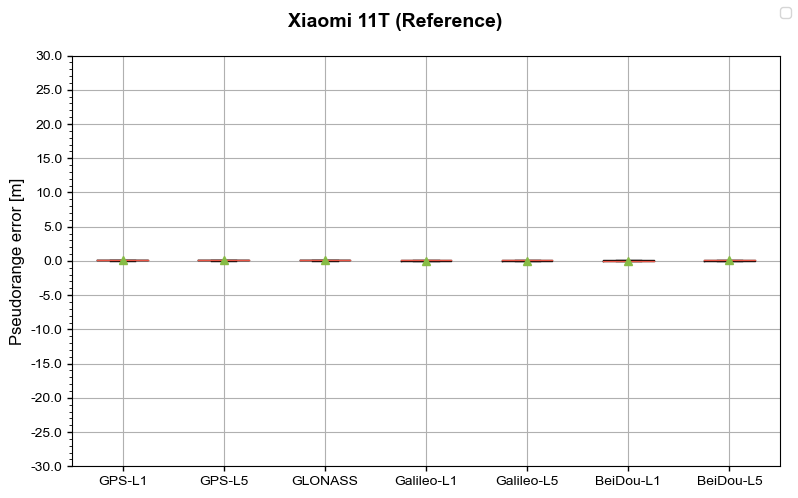

In [18]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'pseudorange_error', 300)
    stats.append(log.ref.df['pseudorange_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))

plotStatisticsDataBox(_logs, 
                      'pseudorange_error', 
                      'Pseudorange error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=30,
                      ticks=[1,5],
                      mode='ref')


In [19]:
_logs = copy.deepcopy(logs)
for log in _logs:
    print(f"--- {log.device} ---")
    log.raw[list(misc.GnssState_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['State'], bits=17, type='tracking'), axis='columns', result_type='expand')
    count = log.raw[list(misc.GnssState_Str.values())].count()
    df = log.raw[list(misc.GnssState_Str.values())].sum().div(count).mul(100).transpose()
    print(df)

--- Pixel 7 ---
TRACK_UNKNOWN                   0.000000
TRACK_CODE_LOCK                71.761994
TRACK_BIT_SYNC                 77.494437
TRACK_SUBFRAME_SYNC            49.214811
TRACK_TOW_DECODED              34.242584
TRACK_MSEC_AMBIGUOUS            0.000000
TRACK_SYMBOL_SYNC              77.499240
TRACK_GLO_STRING_SYNC           2.788583
TRACK_GLO_TOD_DECODED           2.566073
TRACK_BDS_D2_BIT_SYNC           0.000000
TRACK_BDS_D2_SUBFRAME_SYNC      0.000000
TRACK_GAL_E1BC_CODE_LOCK       14.997839
TRACK_GAL_E1C_2ND_CODE_LOCK    27.040612
TRACK_GAL_E1B_PAGE_SYNC         0.000000
TRACK_SBAS_SYNC                 0.000000
TRACK_TOW_KNOWN                95.761098
TRACK_GLO_TOD_KNOWN             4.238902
TRACK_S_2ND_CODE_LOCK          68.813331
dtype: float64
--- Pixel Watch ---
TRACK_UNKNOWN                   0.000000
TRACK_CODE_LOCK                67.650045
TRACK_BIT_SYNC                 89.949239
TRACK_SUBFRAME_SYNC            42.708271
TRACK_TOW_DECODED              47.885936
TRACK_

Doppler

Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)
Rows removed 0 (0.000%)


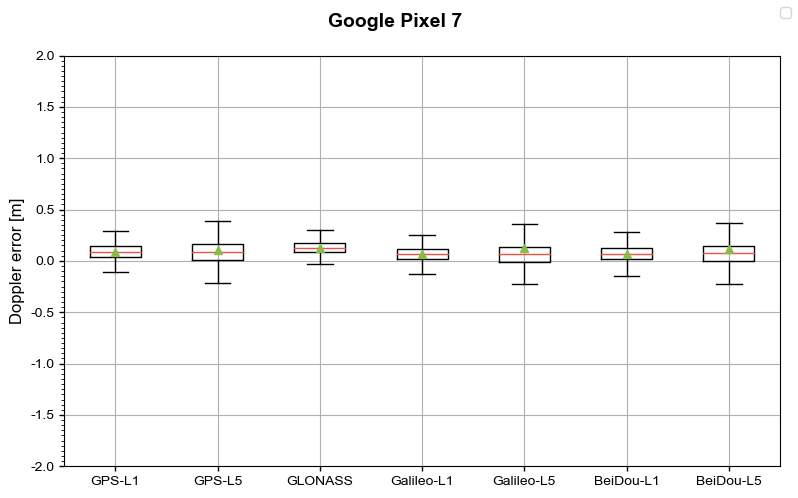

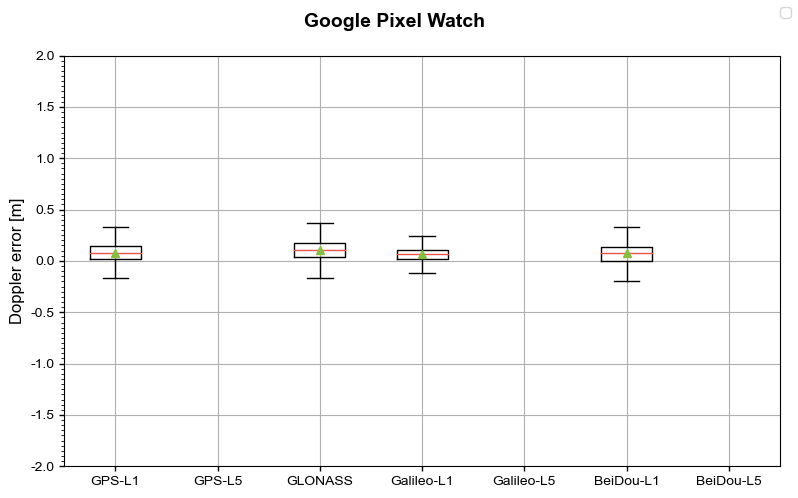

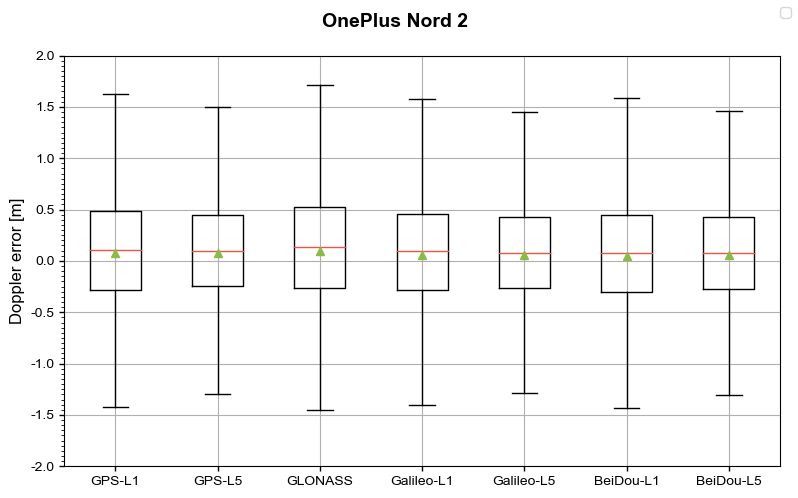

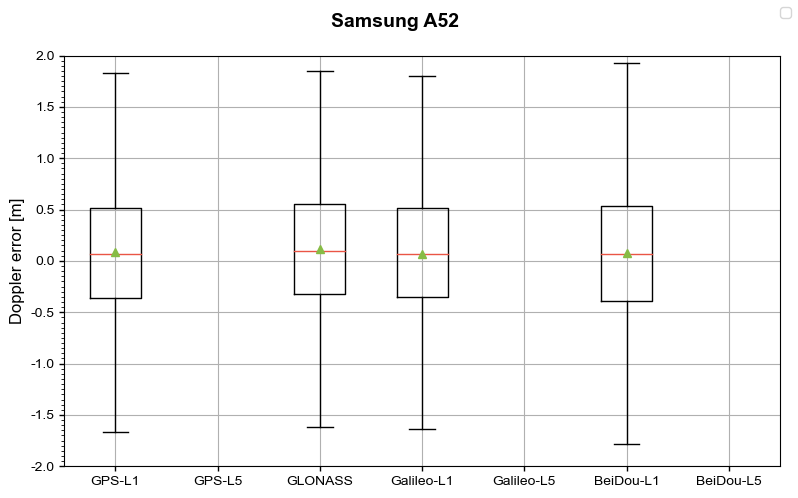

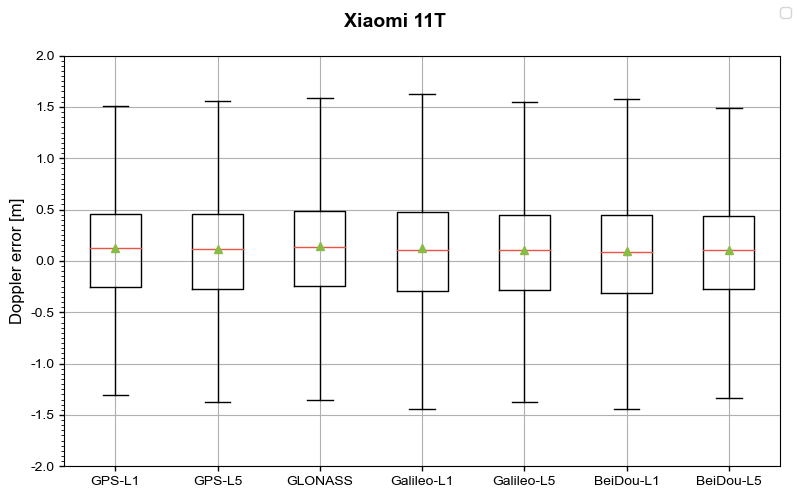

In [20]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw = misc.filterValues(log.raw, 'DopplerError', 300)
plotStatisticsDataBox(_logs, 
                      'DopplerError', 
                      'Doppler error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5])

--- Pixel 7 ---
Rows removed 0 (0.000%)
--- Pixel Watch ---
Rows removed 0 (0.000%)
--- Nord 2 ---
Rows removed 0 (0.000%)
--- A52 ---
Rows removed 0 (0.000%)
--- 11T ---
Rows removed 0 (0.000%)
           Pixel 7  Pixel Watch       Nord 2          A52          11T
count  7872.000000  5893.000000  7277.000000  8060.000000  6936.000000
mean     -0.275235    -0.269724    -0.255703    -0.287470    -0.288284
std       0.228998     0.230950     0.239460     0.220774     0.233834
min      -0.964567    -0.983900    -1.013133    -1.246600    -1.013567
50%      -0.258350    -0.226533    -0.214733    -0.282517    -0.283483
66.7%    -0.124833    -0.127241    -0.074879    -0.168098    -0.117912
95%       0.014193     0.010467     0.015227     0.011735     0.009842
99.7%     0.061134     0.038322     0.062469     0.047737     0.048275
max       0.150033     1.011500     0.205867     0.090900     0.065567


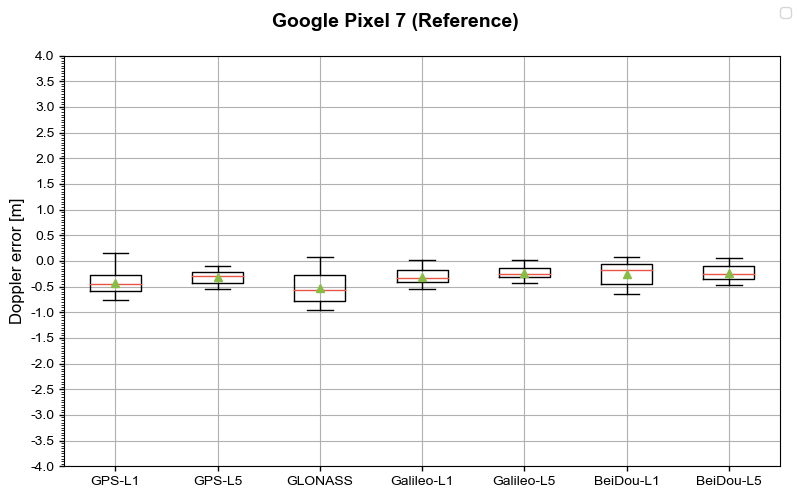

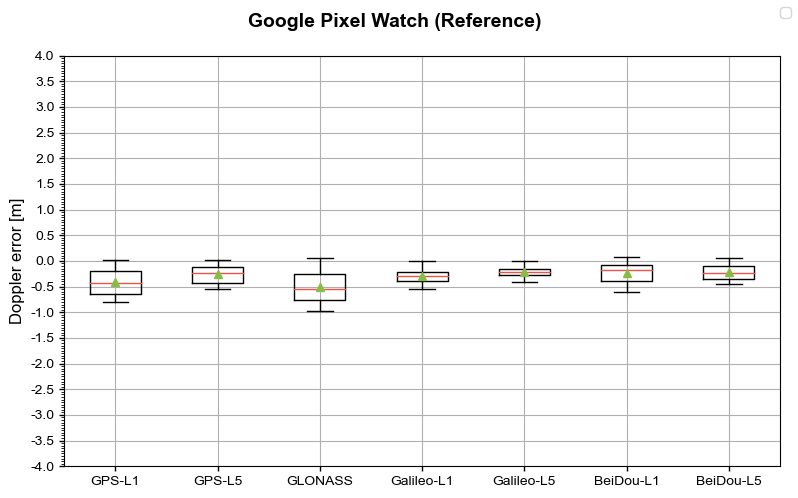

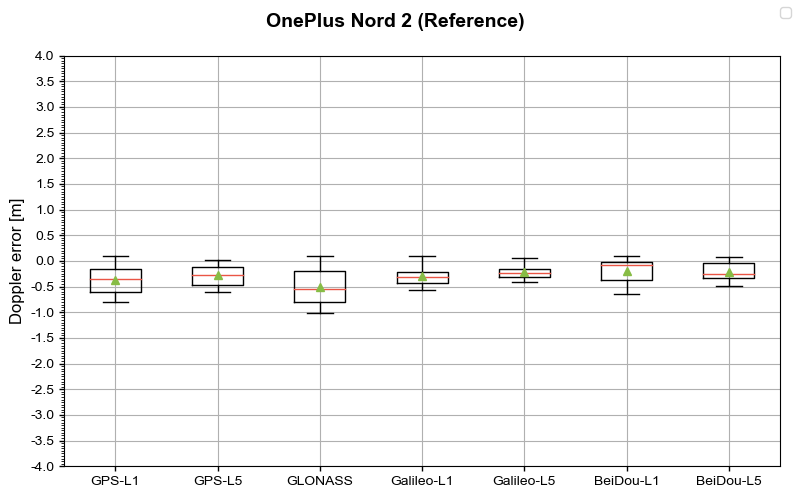

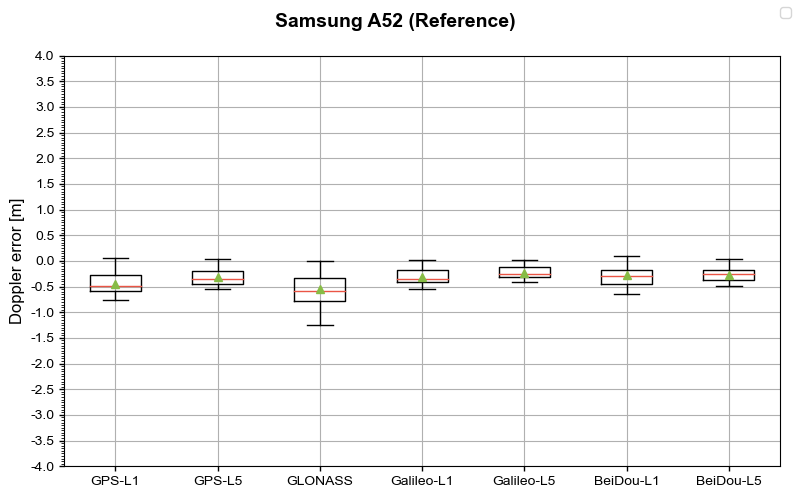

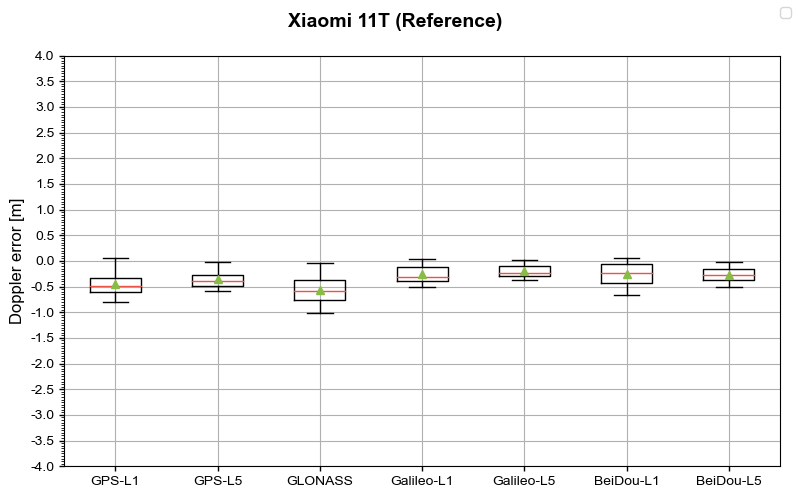

In [21]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'doppler_error', 30)
    #log.raw = misc.filterPercentile(log.raw, 'DopplerError', 0.997)
    stats.append(log.ref.df['doppler_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))

plotStatisticsDataBox(_logs, 
                      'doppler_error', 
                      'Doppler error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=4,
                      ticks=[0.05,0.5],
                      mode='ref')

Phases

--- Pixel 7 ---
Rows removed 449 (0.719%)
count    62020.000000
mean         0.089458
std          0.575235
min        -20.030491
50%          0.073663
66.7%        0.106081
95%          0.321502
99.7%        2.516578
max         21.324966
Name: PhaseError, dtype: float64
--- Pixel Watch ---
Rows removed 234 (0.699%)
count    33256.000000
mean         0.095071
std          0.232739
min         -1.831877
50%          0.081599
66.7%        0.120482
95%          0.377970
99.7%        1.382904
max          1.835072
Name: PhaseError, dtype: float64
--- Nord 2 ---
Rows removed 773 (0.896%)
count    85454.000000
mean         0.141978
std          4.696983
min       -186.762104
50%          0.087092
66.7%        0.284372
95%          1.189747
99.7%       12.475090
max        184.906967
Name: PhaseError, dtype: float64
--- A52 ---
Rows removed 43026 (100.000%)
count    0.0
mean     NaN
std      NaN
min      NaN
50%      NaN
66.7%    NaN
95%      NaN
99.7%    NaN
max      NaN
Name: PhaseError, d

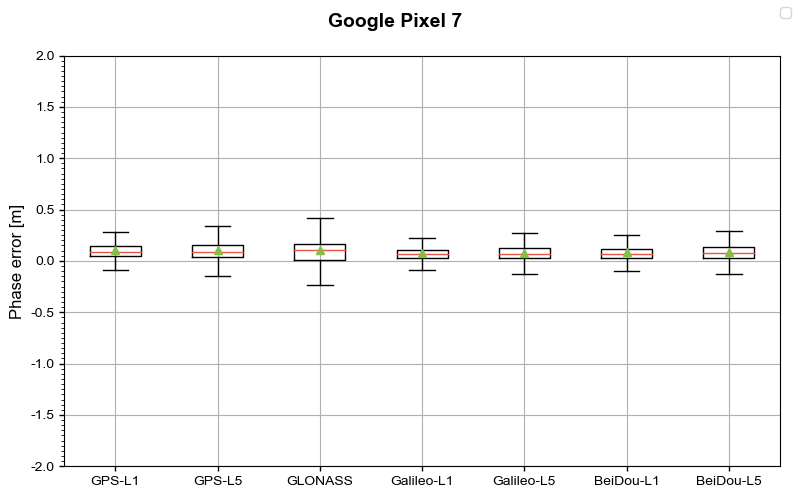

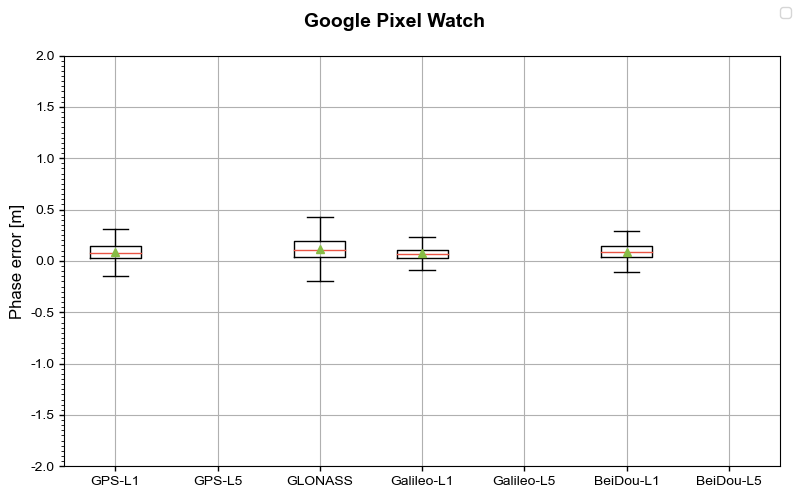

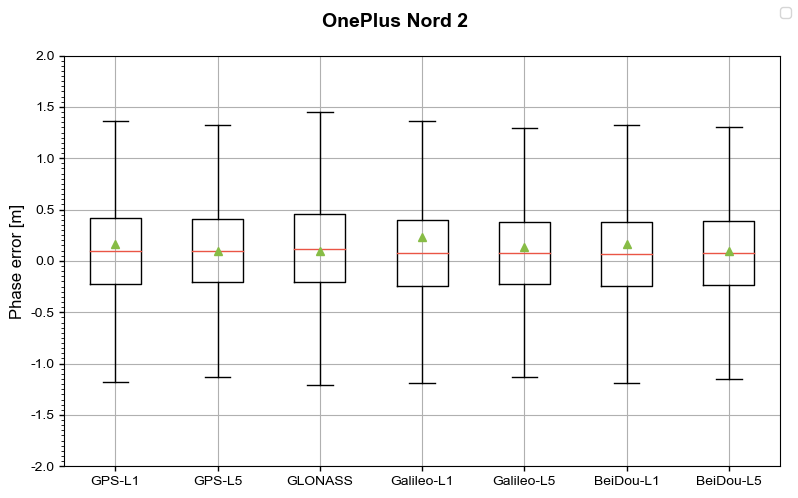

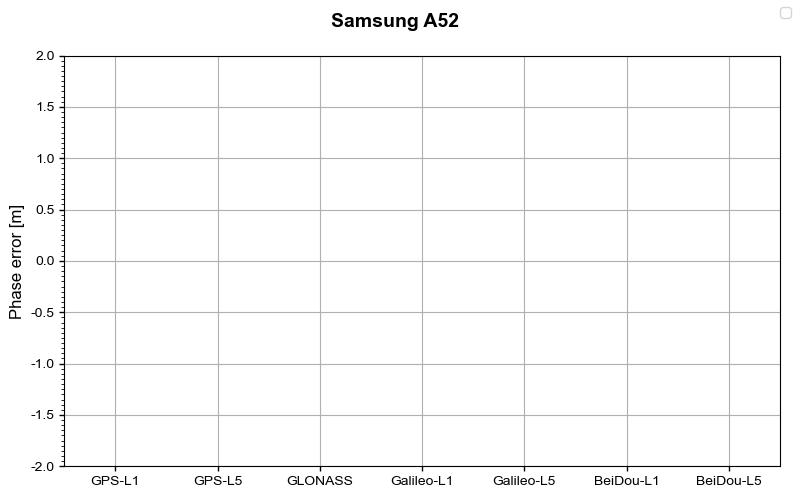

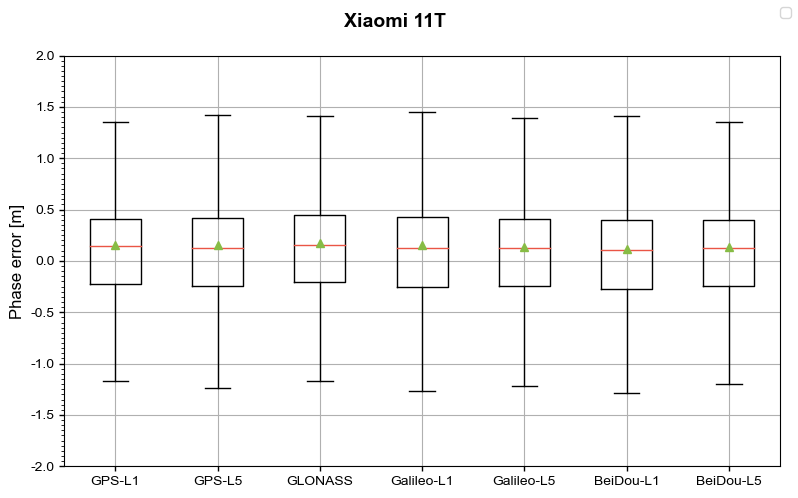

In [22]:
_logs = copy.deepcopy(logs)
for log in _logs:
    print(f"--- {log.device} ---")
    log.raw = misc.filterPercentile(log.raw, 'PhaseError', 0.997)
    print(log.raw['PhaseError'].describe(percentiles=[0.5, .667, .95, .997]).T)
plotStatisticsDataBox(_logs, 
                      'PhaseError', 
                      'Phase error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5])
    

--- Pixel 7 ---
Rows removed 0 (0.000%)
--- Pixel Watch ---
Rows removed 0 (0.000%)
--- Nord 2 ---
Rows removed 0 (0.000%)
--- A52 ---
Rows removed 0 (0.000%)
--- 11T ---
Rows removed 0 (0.000%)
           Pixel 7  Pixel Watch       Nord 2          A52          11T
count  7677.000000  5775.000000  7077.000000  7874.000000  6813.000000
mean      0.279048     0.259336     0.277067     0.289184     0.303618
std       0.230991     0.921531     3.788619     6.191578     1.141953
min      -1.785443   -66.522986  -155.249602  -387.264727    -1.782468
50%       0.264541     0.230098     0.219683     0.288515     0.288231
66.7%     0.377630     0.347343     0.350517     0.391239     0.398452
95%       0.697993     0.713972     0.713753     0.687493     0.672579
99.7%     0.931766     1.774033     0.966652     1.778244     0.951370
max       1.772983     1.788760   155.236628   388.834319    92.258421


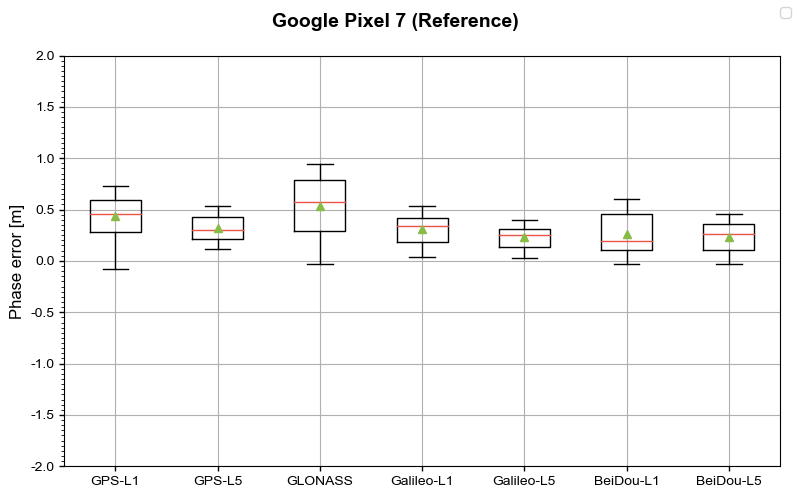

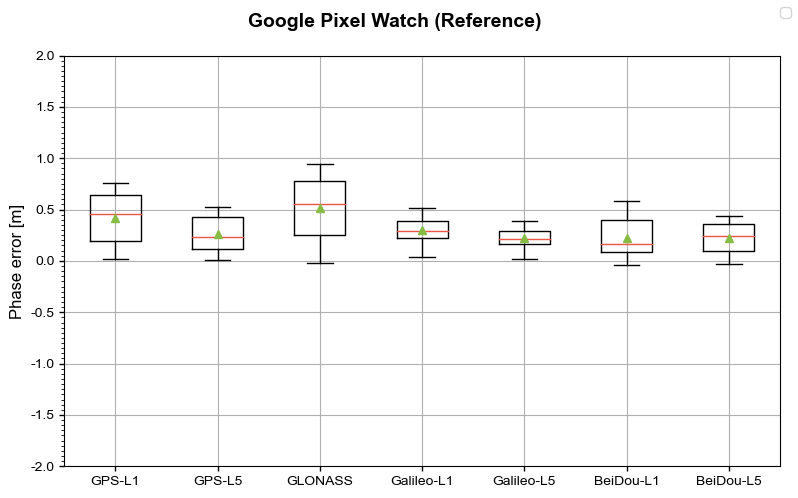

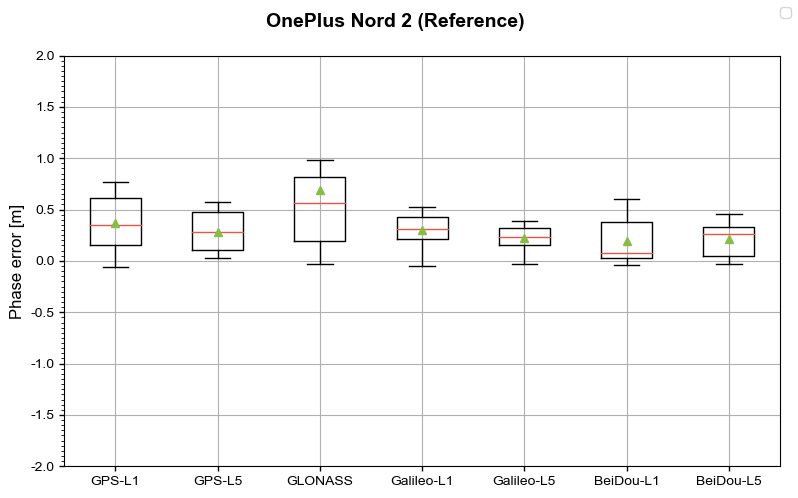

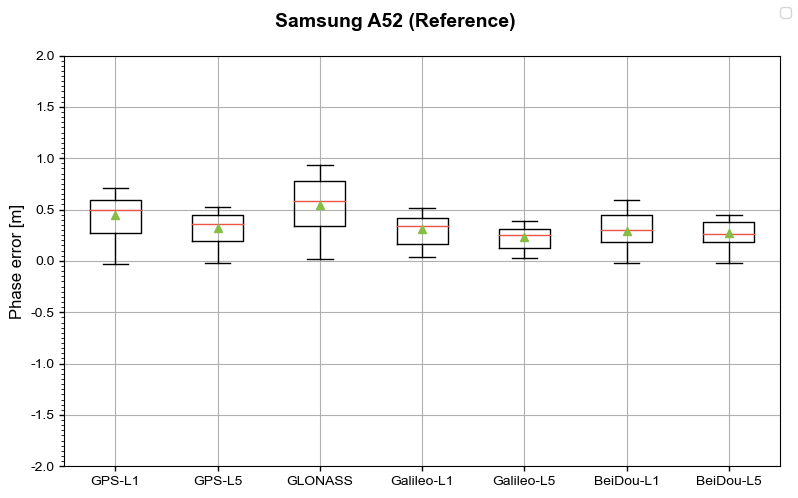

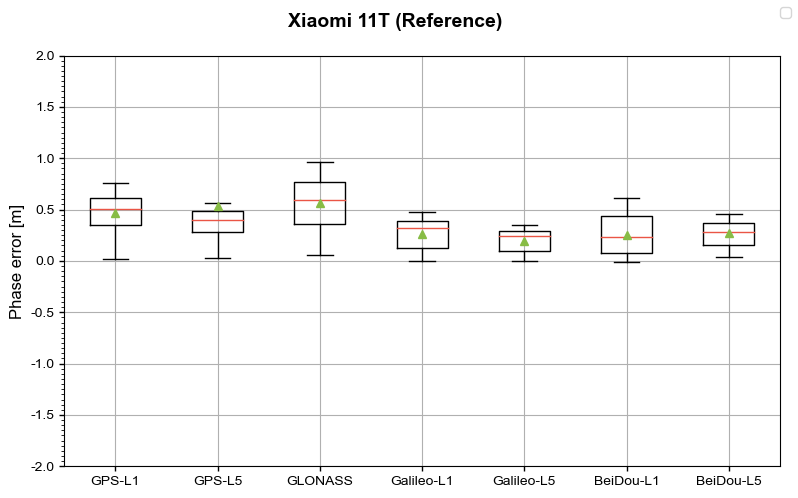

In [23]:
_logs = copy.deepcopy(logs)
stats = []
for log in _logs:
    print(f"--- {log.device} ---")
    log.ref.df = misc.filterValues(log.ref.df, 'phase_error', 500)
    stats.append(log.ref.df['phase_error'].describe(percentiles=[0.5, .667, .95, .997]).T)
print(pd.concat(stats, keys=device_list, axis=1))
plotStatisticsDataBox(_logs, 
                      'phase_error', 
                      'Phase error [m]', 
                      ('G', 'R', 'E', 'C'), 
                      ('L1', 'L5'),
                      lim=2,
                      ticks=[0.05,0.5],
                      mode='ref')

In [24]:
_logs = copy.deepcopy(logs)
for log in _logs:
    log.raw[list(misc.GnssStateADR_Str.values())] = log.raw.apply(lambda row: misc.getSplitState(row['AccumulatedDeltaRangeState'], bits=5, type='phase'), axis='columns', result_type='expand')


In [25]:
for log in _logs:
    print(f"--- {log.device} ---")
    count = log.raw[list(misc.GnssStateADR_Str.values())].count()
    print(log.raw[list(misc.GnssStateADR_Str.values())].sum().div(count).mul(100))

--- Pixel 7 ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   76.770878
ADR_RESET                    0.000000
ADR_CYCLE_SLIP               0.566681
ADR_HALF_CYCLE_RESOLVED     72.644031
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64
--- Pixel Watch ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   78.832487
ADR_RESET                    0.005972
ADR_CYCLE_SLIP               4.643177
ADR_HALF_CYCLE_RESOLVED     67.611227
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64
--- Nord 2 ---
ADR_UNKNOWN                  0.000000
ADR_VALID                   82.392986
ADR_RESET                    0.000000
ADR_CYCLE_SLIP               7.858327
ADR_HALF_CYCLE_RESOLVED     77.790019
ADR_HALF_CYCLE_REPORTED    100.000000
dtype: float64
--- A52 ---
ADR_UNKNOWN                  0.0
ADR_VALID                    0.0
ADR_RESET                    0.0
ADR_CYCLE_SLIP               0.0
ADR_HALF_CYCLE_RESOLVED      0.0
ADR_HALF_CYCLE_REPORTED    100.0
dtype: flo

### C/N0

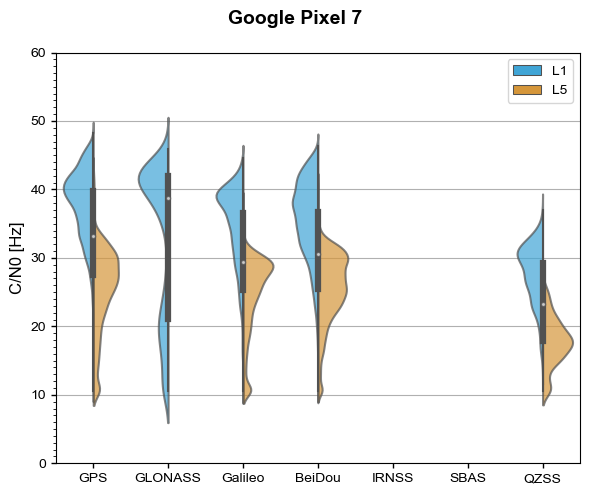

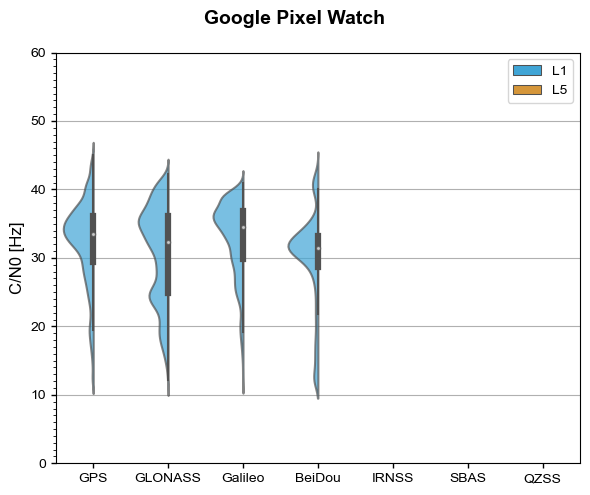

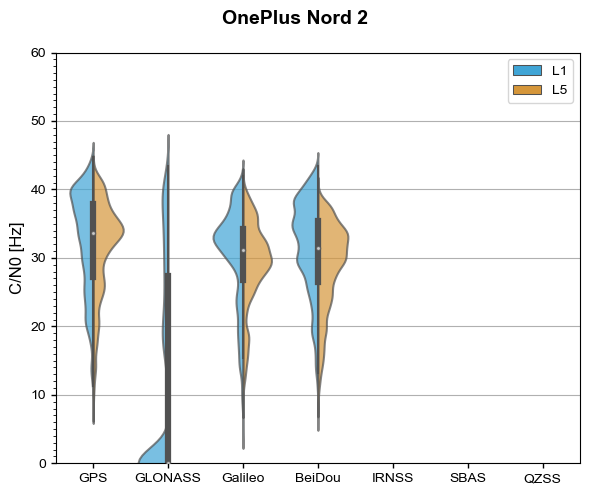

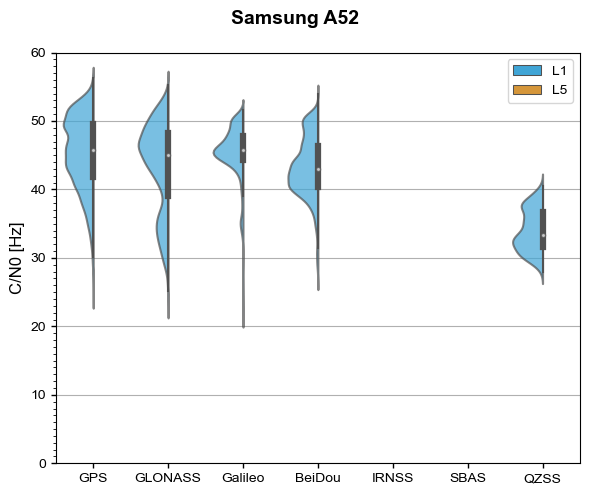

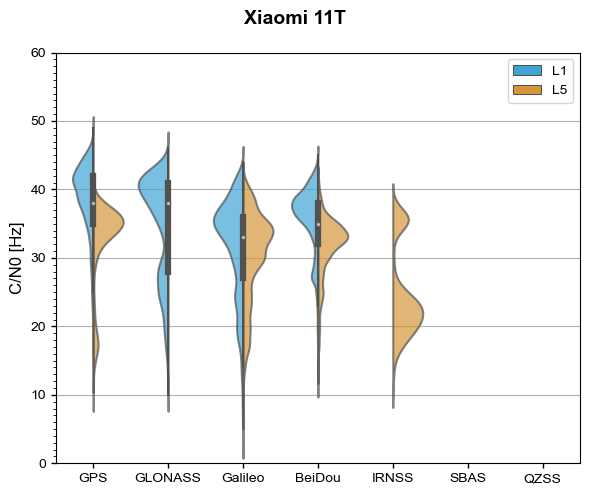

In [26]:
_logs = copy.deepcopy(logs)
plotStatisticsDataViolin(
    _logs, 
    'Cn0DbHz', 
    'C/N0 [Hz]', 
    ('G', 'R', 'E', 'C', 'I', 'S', 'J'), 
    ('L1', 'L5'),
    lim=60,
    ticks=[1,10])

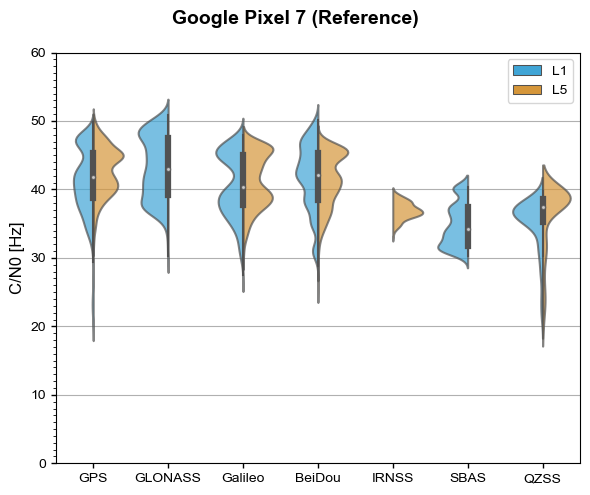

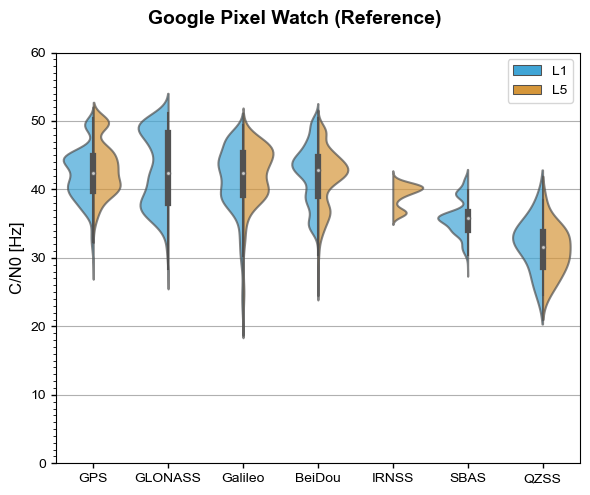

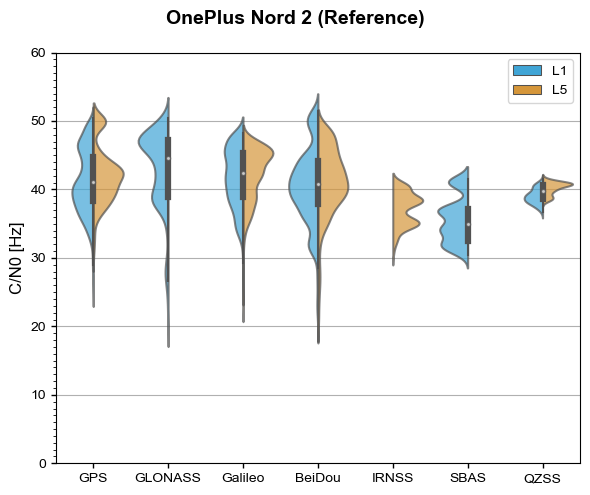

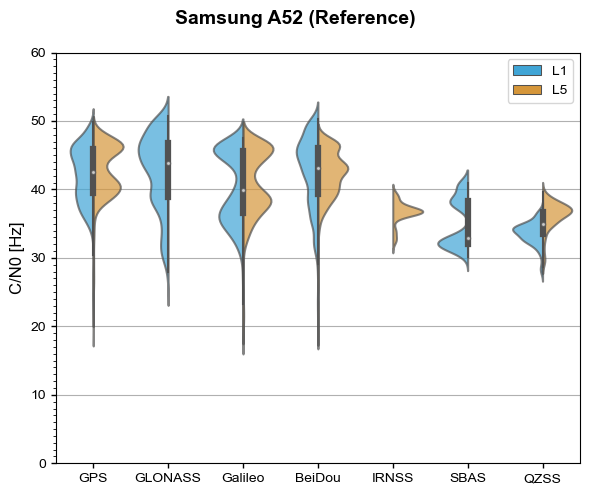

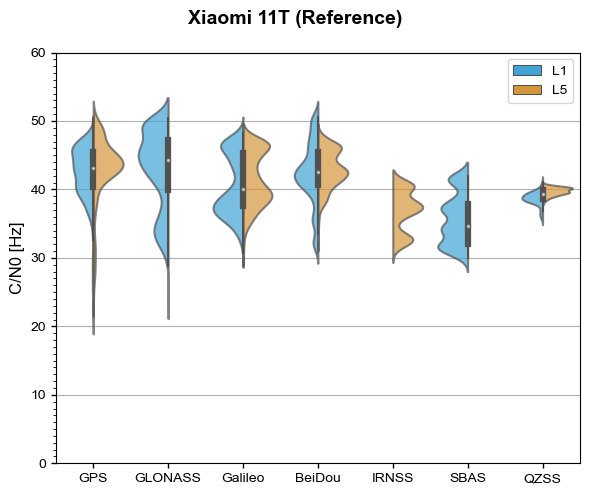

In [27]:
plotStatisticsDataViolin(
    _logs, 
    'snr', 
    'C/N0 [Hz]', 
    ('G', 'R', 'E', 'C', 'I', 'S', 'J'), 
    ('L1', 'L5'),
    lim=60,
    ticks=[1,10],
    mode='ref')